<a href="https://colab.research.google.com/github/UNT-CSCE-Projects/UNT-CSE-SpaceshipTitanic/blob/dev_avijeet/Spaceship_notebook_avijeet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
# import packages, libraries
import pandas as pd
from sklearn import metrics
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from google.colab import drive

In [86]:

### Connect with google drive
def connect_and_fetch_train():

  drive.mount('/content/drive')

  ### Train & Test csv dir

  train_file = "1aFLIETCp08ZRwvYj29MPeHokzltUywhv"
  test_file = "1wB9wtBDqedOlLeVfnaMY0b_oTXmu3rg4"


  train_dir = f'https://drive.google.com/uc?id={train_file}'
  return train_dir

def connect_and_fetch_test():
  drive.mount('/content/drive')

  ### Train & Test csv dir

  test_file = "1wB9wtBDqedOlLeVfnaMY0b_oTXmu3rg4"


  test_dir = f'https://drive.google.com/uc?id={test_file}'
  return test_dir



In [87]:
df_train = pd.read_csv(connect_and_fetch_train())
df_test = pd.read_csv(connect_and_fetch_test())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
from sklearn.utils import shuffle
df_train = shuffle(df_train)

In [89]:
def split_cabin(df):
  df[['deck','num','side']]=df['Cabin'].str.split('/',expand=True)

  return df

df_train = split_cabin(df_train)
df_test = split_cabin(df_test)


In [90]:
label_cols = ["HomePlanet", "CryoSleep","deck","side", "Destination" ,"VIP"]
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train ,test = label_encoder(df_train,df_test ,label_cols)

In [91]:
def preprocessing_missing_value(df):
  df['Destination'].fillna(df['Destination'].mode()[0], inplace=True)
  df['CryoSleep'].fillna(df['CryoSleep'].mode()[0], inplace=True)
  df['RoomService'].fillna(df['RoomService'].min(), inplace=True)
  df['FoodCourt'].fillna(df['FoodCourt'].mean(), inplace=True)
  df['VIP'].fillna(df['VIP'].mode()[0],inplace = True)
  df['Age'].fillna(df['Age'].mode()[0],inplace = True)
  df['Spa'].fillna(df['Spa'].mean(), inplace = True)
  df['Cabin'].fillna(df['Cabin'].mode(), inplace = True)
  df['VRDeck'].fillna(df['VRDeck'].median(), inplace = True)
  df['ShoppingMall'].fillna(df['ShoppingMall'].mean(), inplace = True)
  df['HomePlanet'].fillna(df['HomePlanet'].mode()[0],inplace = True)
  df['deck'].fillna(df['deck'].mode()[0],inplace = True)
  df['side'].fillna(df['side'].mode()[0],inplace = True)
  df['num'].fillna(df['num'].median(), inplace = True)
  df['num'] = df['num'].astype('int')
  return df

df_train = preprocessing_missing_value(df_train)
df_test = preprocessing_missing_value(df_test)


In [92]:
# required models
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import AdaBoostClassifier

def split_data(df):
   X = df.drop(columns=['Transported','PassengerId','Cabin','Name'])
   y = df['Transported']
   X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=1,shuffle=True)
   return X_train, X_test, y_train, y_test

def print_confusion_matrix(confusion_matrix):
  f, ax=plt.subplots(figsize=(5,5))
  sns.heatmap(confusion_matrix,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
  plt.xlabel("Predicted Transported")
  plt.ylabel("Actual Transported")
  plt.show()

def train_classifiers(X_train, y_train):
    classifiers = {
        'Naive Bayes': BernoulliNB(),
        'KNN': KNeighborsClassifier(n_jobs=-1),
        'Logistic Regression': LogisticRegression(n_jobs=-1),
        'Decision Tree': DecisionTreeClassifier(criterion='entropy', random_state=272),
        'Random Forest': RandomForestClassifier(max_depth=11, n_estimators=100, random_state=200),
        'AdaBoost': AdaBoostClassifier(n_estimators=150, random_state=42, learning_rate=1),
        'XGBoost': XGBClassifier(gamma=1.5, subsample=1.0, max_depth=5, colsample_bytree=1.0, n_estimators=150)
    }

    for classifier_name, classifier in classifiers.items():
        classifier.fit(X_train, y_train)

    return classifiers


In [93]:
def models_on_training(X_train, y_train):

    # get pretrained models
    classifiers = train_classifiers(X_train, y_train)


    for name, instance in classifiers.items():
        print(f'============================== {name} Training Model Evaluation ==============================')
        print(f'Cross-validation Mean : {cross_val_score(instance, X_train, y_train, cv=10).mean()}\n')
        print(f'Model Accuracy(Training): {metrics.accuracy_score(y_train, instance.predict(X_train))}\n')
        print(f'Confusion Matrix :\n ')
        print(print_confusion_matrix( metrics.confusion_matrix(y_train, instance.predict(X_train))))
        print(f'Classification report: {metrics.classification_report(y_train, instance.predict(X_train))}\n' )


    return classifiers

def model_performance_in_test(models, X_test, y_test):
  for name, instance in models.items():
    print(f'============================== {name} Model Test Results ==============================')
    print (f'Model Accuracy(Testing): {metrics.accuracy_score(y_test, instance.predict(X_test))}' )
    print(f'Confusion Matrix :\n')
    print_confusion_matrix(metrics.confusion_matrix(y_test, instance.predict(X_test)))
    print(f'Classification report: {metrics.classification_report(y_test, instance.predict(X_test))}\n')

In [94]:
def pipeline(df):
  X_train, X_test, y_train, y_test = split_data(df)
  models = models_on_training(X_train, y_train)
  model_performance_in_test(models, X_test, y_test)


============================== Naive Bayes Training Model Evaluation ==============================
Cross-validation Mean : 0.7364107334821797

Model Accuracy(Training): 0.7365545010066149

Confusion Matrix :
 


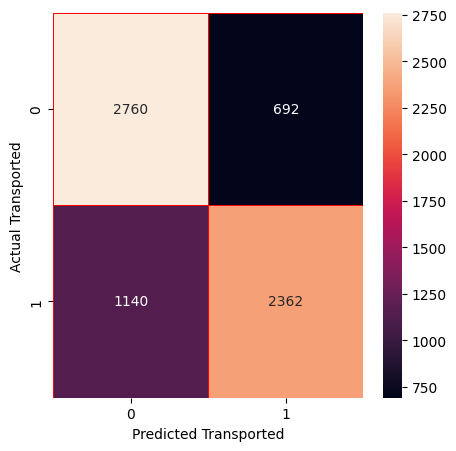

None
Classification report:               precision    recall  f1-score   support

       False       0.71      0.80      0.75      3452
        True       0.77      0.67      0.72      3502

    accuracy                           0.74      6954
   macro avg       0.74      0.74      0.74      6954
weighted avg       0.74      0.74      0.74      6954


============================== KNN Training Model Evaluation ==============================
Cross-validation Mean : 0.7651703464814356

Model Accuracy(Training): 0.8258556226632154

Confusion Matrix :
 


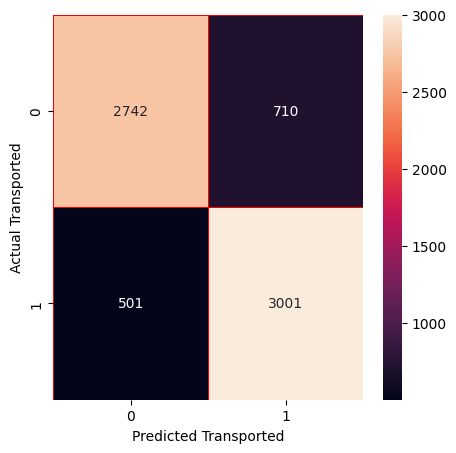

None
Classification report:               precision    recall  f1-score   support

       False       0.85      0.79      0.82      3452
        True       0.81      0.86      0.83      3502

    accuracy                           0.83      6954
   macro avg       0.83      0.83      0.83      6954
weighted avg       0.83      0.83      0.83      6954


============================== Logistic Regression Training Model Evaluation ==============================
Cross-validation Mean : 0.7815602001157694

Model Accuracy(Training): 0.7786885245901639

Confusion Matrix :
 


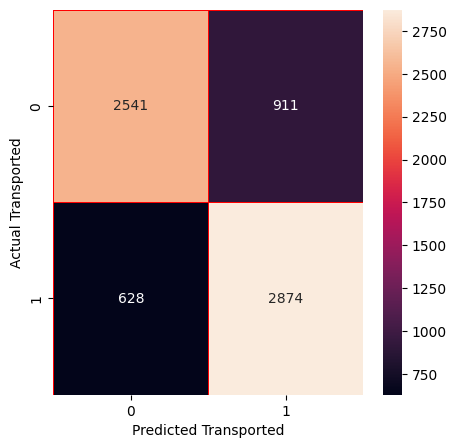

None
Classification report:               precision    recall  f1-score   support

       False       0.80      0.74      0.77      3452
        True       0.76      0.82      0.79      3502

    accuracy                           0.78      6954
   macro avg       0.78      0.78      0.78      6954
weighted avg       0.78      0.78      0.78      6954


============================== Decision Tree Training Model Evaluation ==============================
Cross-validation Mean : 0.7516468204746548

Model Accuracy(Training): 0.999712395743457

Confusion Matrix :
 


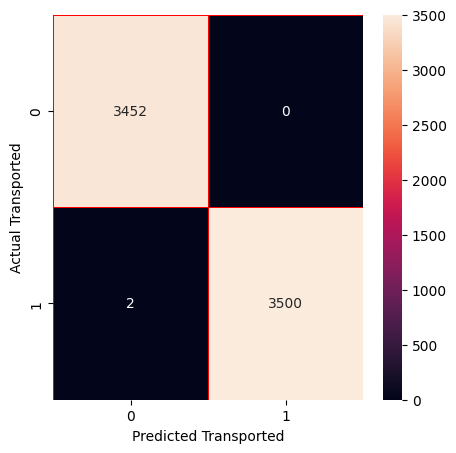

None
Classification report:               precision    recall  f1-score   support

       False       1.00      1.00      1.00      3452
        True       1.00      1.00      1.00      3502

    accuracy                           1.00      6954
   macro avg       1.00      1.00      1.00      6954
weighted avg       1.00      1.00      1.00      6954


============================== Random Forest Training Model Evaluation ==============================
Cross-validation Mean : 0.8014057719341767

Model Accuracy(Training): 0.8885533505895887

Confusion Matrix :
 


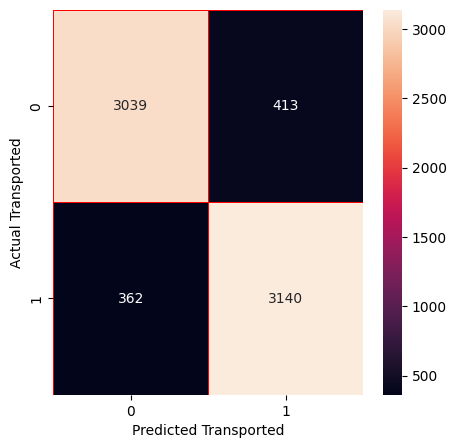

None
Classification report:               precision    recall  f1-score   support

       False       0.89      0.88      0.89      3452
        True       0.88      0.90      0.89      3502

    accuracy                           0.89      6954
   macro avg       0.89      0.89      0.89      6954
weighted avg       0.89      0.89      0.89      6954


============================== AdaBoost Training Model Evaluation ==============================
Cross-validation Mean : 0.7924904903663277

Model Accuracy(Training): 0.8068737417313776

Confusion Matrix :
 


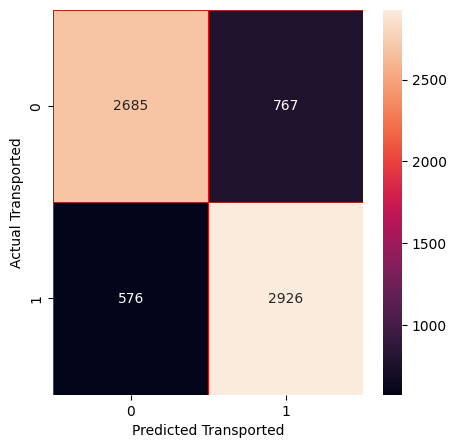

None
Classification report:               precision    recall  f1-score   support

       False       0.82      0.78      0.80      3452
        True       0.79      0.84      0.81      3502

    accuracy                           0.81      6954
   macro avg       0.81      0.81      0.81      6954
weighted avg       0.81      0.81      0.81      6954


============================== XGBoost Training Model Evaluation ==============================
Cross-validation Mean : 0.8048596295377491

Model Accuracy(Training): 0.8639631866551625

Confusion Matrix :
 


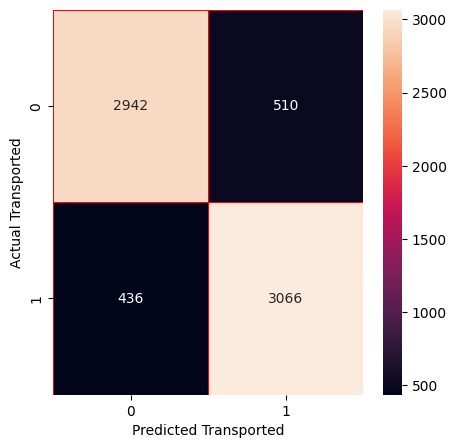

None
Classification report:               precision    recall  f1-score   support

       False       0.87      0.85      0.86      3452
        True       0.86      0.88      0.87      3502

    accuracy                           0.86      6954
   macro avg       0.86      0.86      0.86      6954
weighted avg       0.86      0.86      0.86      6954


============================== Naive Bayes Model Test Results ==============================
Model Accuracy(Testing): 0.7331799884991375
Confusion Matrix :



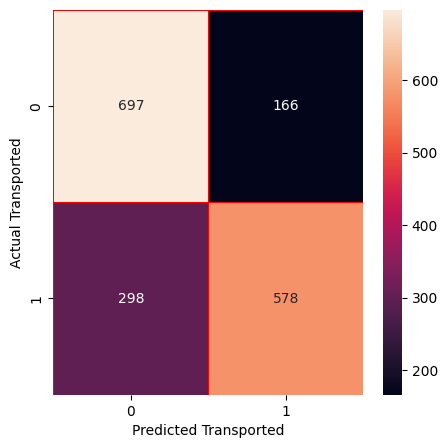

Classification report:               precision    recall  f1-score   support

       False       0.70      0.81      0.75       863
        True       0.78      0.66      0.71       876

    accuracy                           0.73      1739
   macro avg       0.74      0.73      0.73      1739
weighted avg       0.74      0.73      0.73      1739


============================== KNN Model Test Results ==============================
Model Accuracy(Testing): 0.7745830937320299
Confusion Matrix :



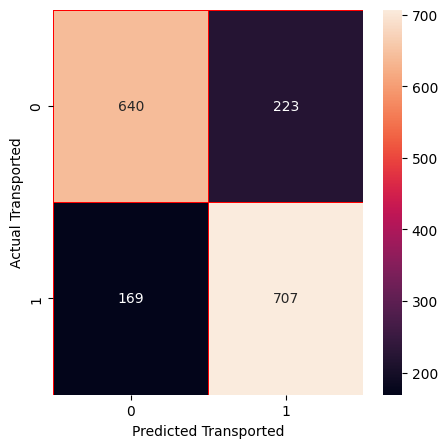

Classification report:               precision    recall  f1-score   support

       False       0.79      0.74      0.77       863
        True       0.76      0.81      0.78       876

    accuracy                           0.77      1739
   macro avg       0.78      0.77      0.77      1739
weighted avg       0.78      0.77      0.77      1739


============================== Logistic Regression Model Test Results ==============================
Model Accuracy(Testing): 0.7751581368602645
Confusion Matrix :



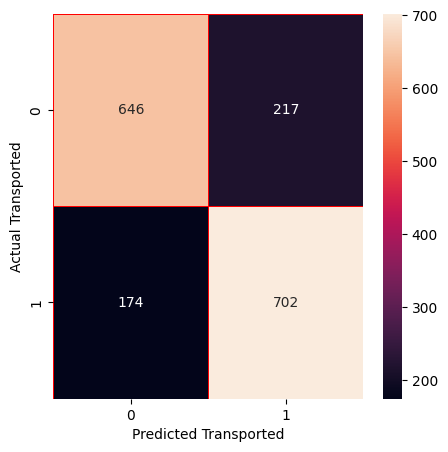

Classification report:               precision    recall  f1-score   support

       False       0.79      0.75      0.77       863
        True       0.76      0.80      0.78       876

    accuracy                           0.78      1739
   macro avg       0.78      0.77      0.77      1739
weighted avg       0.78      0.78      0.77      1739


============================== Decision Tree Model Test Results ==============================
Model Accuracy(Testing): 0.7481311098332375
Confusion Matrix :



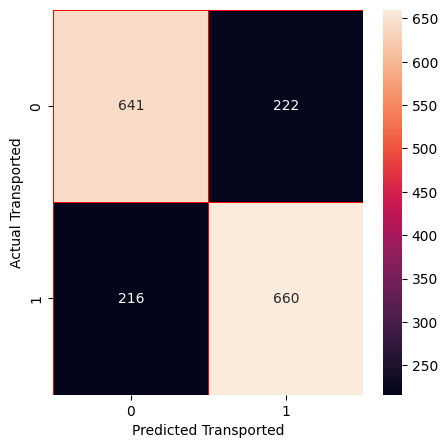

Classification report:               precision    recall  f1-score   support

       False       0.75      0.74      0.75       863
        True       0.75      0.75      0.75       876

    accuracy                           0.75      1739
   macro avg       0.75      0.75      0.75      1739
weighted avg       0.75      0.75      0.75      1739


============================== Random Forest Model Test Results ==============================
Model Accuracy(Testing): 0.80448533640023
Confusion Matrix :



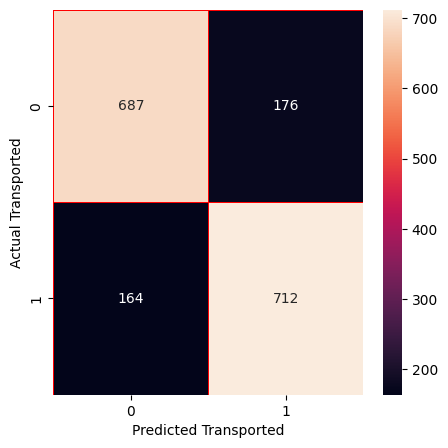

Classification report:               precision    recall  f1-score   support

       False       0.81      0.80      0.80       863
        True       0.80      0.81      0.81       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


============================== AdaBoost Model Test Results ==============================
Model Accuracy(Testing): 0.7883841288096607
Confusion Matrix :



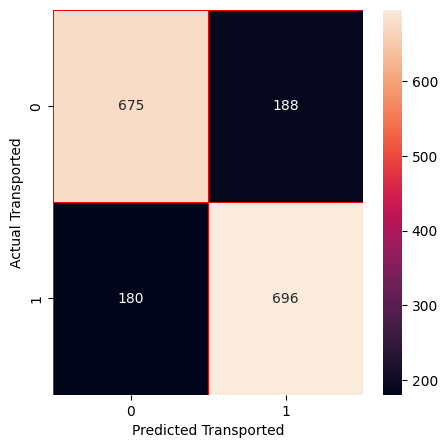

Classification report:               precision    recall  f1-score   support

       False       0.79      0.78      0.79       863
        True       0.79      0.79      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739


============================== XGBoost Model Test Results ==============================
Model Accuracy(Testing): 0.8125359401955147
Confusion Matrix :



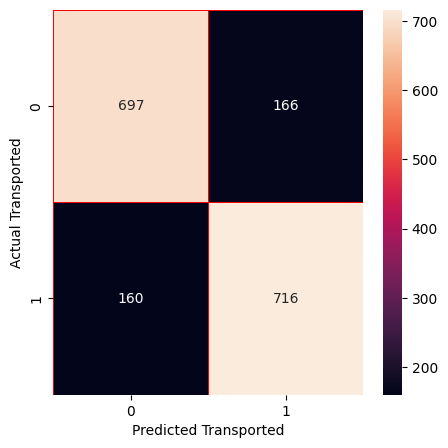

Classification report:               precision    recall  f1-score   support

       False       0.81      0.81      0.81       863
        True       0.81      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739




In [95]:
pipeline(df_train)

# Saving the best model in pickle


In [96]:
# import pickle
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# model.fit(X_train, y_train)
# with open('model.pickle', 'wb') as f:
#     pickle.dump(model, f)